In [3]:
import sys
sys.path.append('../..')

%load_ext autoreload
%autoreload 2
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from skimage.io import imread
import cv2

from gen.load_data import load_data
from gen.generators import preprocess_label


In [7]:
train_df, valid_df, test_df = load_data('../../data')

In [8]:
train_df.head()

,image,id,label
0,../../data/Train/CameraRGB/episode_0002_000287...,episode_0002_000287,../../data/Train/CameraSeg/episode_0002_000287...
1,../../data/Train/CameraRGB/episode_0008_000112...,episode_0008_000112,../../data/Train/CameraSeg/episode_0008_000112...
2,../../data/Train/CameraRGB/804.png,804,../../data/Train/CameraSeg/804.png
3,../../data/Train/CameraRGB/episode_0008_000286...,episode_0008_000286,../../data/Train/CameraSeg/episode_0008_000286...
4,../../data/Train/CameraRGB/M2-25.png,M2-25,../../data/Train/CameraSeg/M2-25.png


In [9]:
valid_df.head()

,image,id,label
0,../../data/Valid/CameraRGB/00019.png,00019,../../data/Valid/CameraSeg/00019.png
1,../../data/Valid/CameraRGB/episode_0005_000117...,episode_0005_000117,../../data/Valid/CameraSeg/episode_0005_000117...
2,../../data/Valid/CameraRGB/00413.png,00413,../../data/Valid/CameraSeg/00413.png
3,../../data/Valid/CameraRGB/00035.png,00035,../../data/Valid/CameraSeg/00035.png
4,../../data/Valid/CameraRGB/00264.png,00264,../../data/Valid/CameraSeg/00264.png


In [10]:
test_df.head()

,image,id,label
0,../../data/Test/CameraRGB/episode_0008_000112.png,episode_0008_000112,../../data/Test/CameraSeg/episode_0008_000112.png
1,../../data/Test/CameraRGB/00019.png,00019,../../data/Test/CameraSeg/00019.png
2,../../data/Test/CameraRGB/episode_0012_000130.png,episode_0012_000130,../../data/Test/CameraSeg/episode_0012_000130.png
3,../../data/Test/CameraRGB/episode_0010_000160.png,episode_0010_000160,../../data/Test/CameraSeg/episode_0010_000160.png
4,../../data/Test/CameraRGB/00413.png,00413,../../data/Test/CameraSeg/00413.png


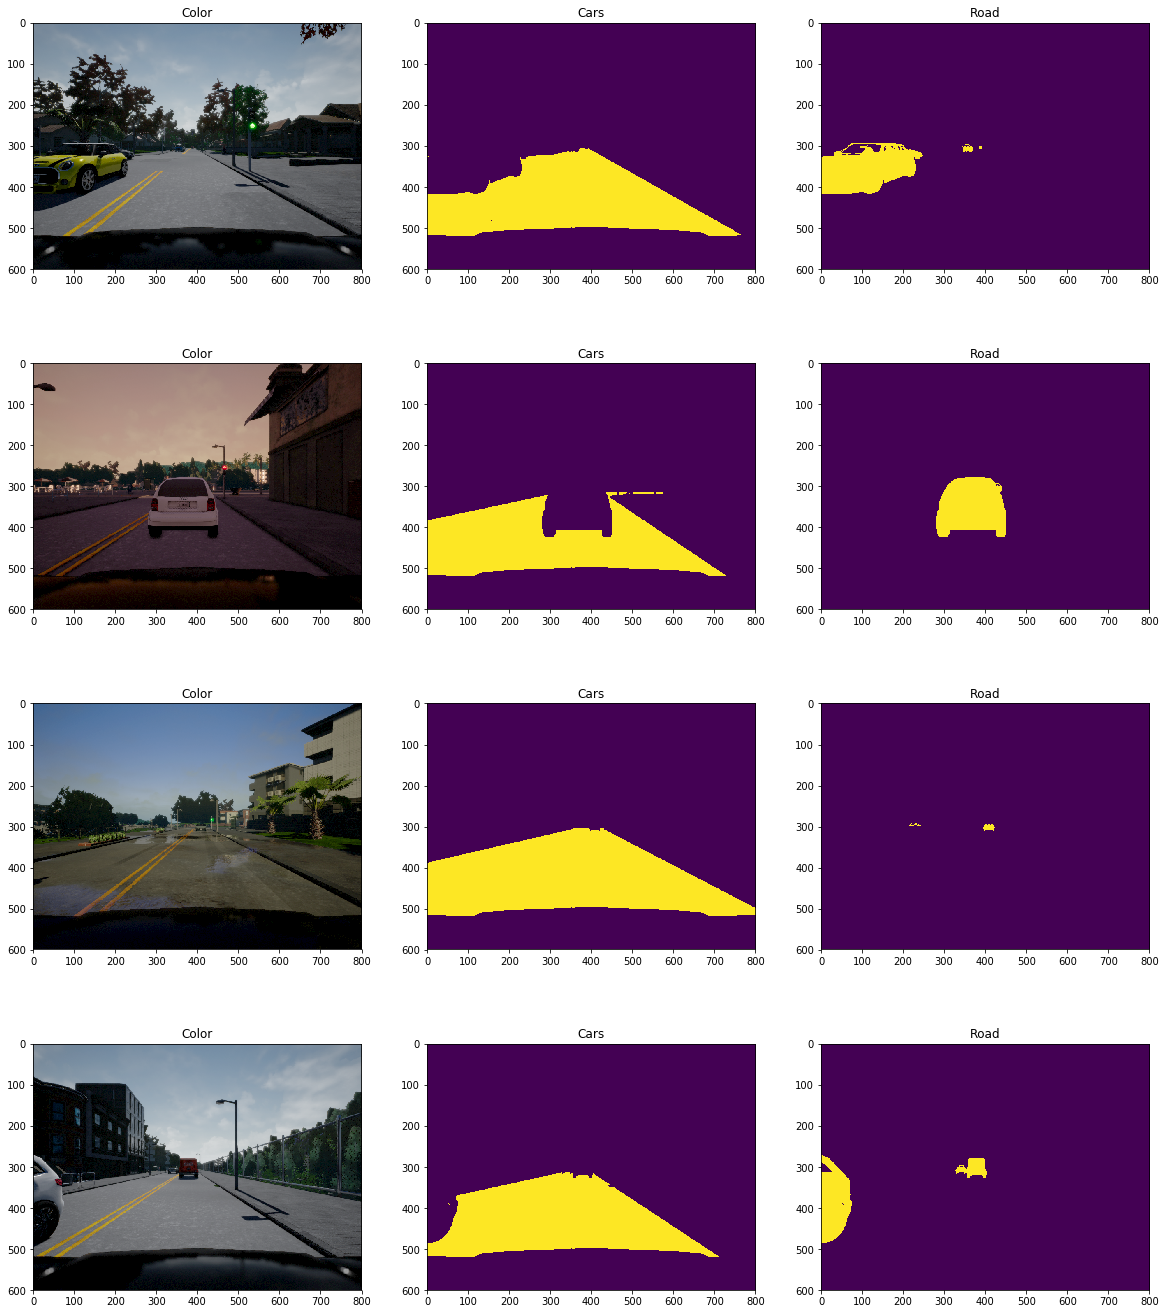

In [11]:
sample_rows = 4
fig, m_axs = plt.subplots(sample_rows, 3, figsize = (20, 6*sample_rows))
for (ax1, ax2, ax3), (_, c_row) in zip(m_axs, train_df.sample(sample_rows).iterrows()):
    c_img = imread(c_row['image'])
    
    l_img = imread(c_row['label'])
    
    lbls = np.zeros_like(l_img)
    lbls[l_img == 10] = 1
    lbls[l_img == 7] = 2
    
    ax1.imshow(c_img)
    ax1.set_title('Color')    
    ax2.imshow(preprocess_label(l_img)[:, :, 1])
    ax2.set_title('Cars')
    ax3.imshow(preprocess_label(l_img)[:, :, 0])
    ax3.set_title('Road')

In [17]:
from gen.generators import gen_func, preprocess_label, preprocess_multi_label
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input

img_gen_args = dict(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.1, 
                              width_shift_range = 0.1, 
                              rotation_range = 3, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range = 0.05)

rgb_gen = ImageDataGenerator(**img_gen_args)
lab_gen = ImageDataGenerator(preprocessing_function = preprocess_multi_label, **img_gen_args)

rgb_gen2 = ImageDataGenerator(preprocessing_function=preprocess_input)
lab_gen2 = ImageDataGenerator(preprocessing_function = preprocess_multi_label)

train_and_lab_gen = gen_func(train_df, rgb_gen, lab_gen, image_size=(600, 800), target_size=(600, 800), batch_size = 32)
valid_and_lab_gen = gen_func(valid_df, rgb_gen2, lab_gen2, image_size=(600, 800), target_size=(480, 480), batch_size = 32)
test_and_lab_gen = gen_func(test_df, rgb_gen2, lab_gen2, image_size=(600, 800),  target_size=(480, 480), batch_size = 32)

In [18]:
(rgb_batch, lab_batch) = next(train_and_lab_gen)




## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 5804 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 5804 images


ValueError: could not broadcast input array from shape (600,800,12) into shape (600,800,3)

(320, 416, 3)


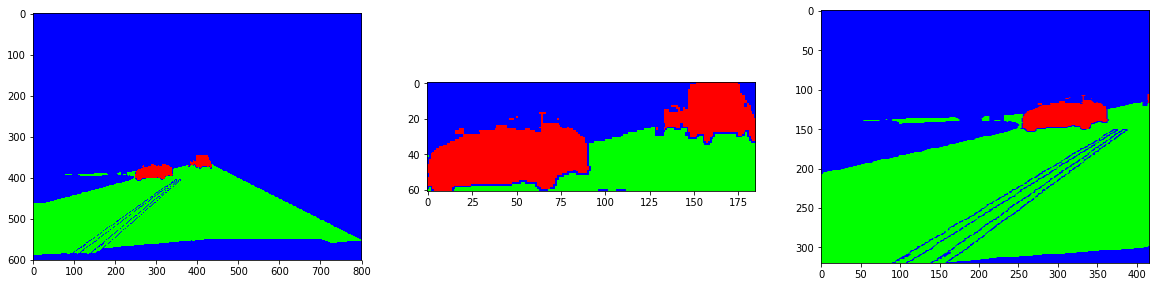

In [95]:
lab = lab_batch[2]
car = lab[: , : , :]

xd, yd = car[:, :, 0].nonzero()

x0, x1 = xd.min(), xd.max()
y0, y1 = yd.min(), yd.max()

y_ = 416 - (y1-y0)
x_ = 320 - (x1-x0)

if x_ > 0:
    b = x_ - (496 - x1)
    x0, x1 = x0-(x_-b), x1 + b
if y_ > 0:
    r = np.random.randint(0, y_)
    y0, y1 = y0-(y_-r), y+r
    

patch = lab[xd.min():xd.max(), yd.min():yd.max(), :]
patch2 = cv2.resize(lab[x0:x1, y0:y1, :], (416, 320))

print (patch2.shape)

plt.figure(figsize=(20, 10))
plt.subplot(131)
plt.imshow(car)
plt.subplot(132)
plt.imshow(patch)
plt.subplot(133)
plt.imshow(patch2)

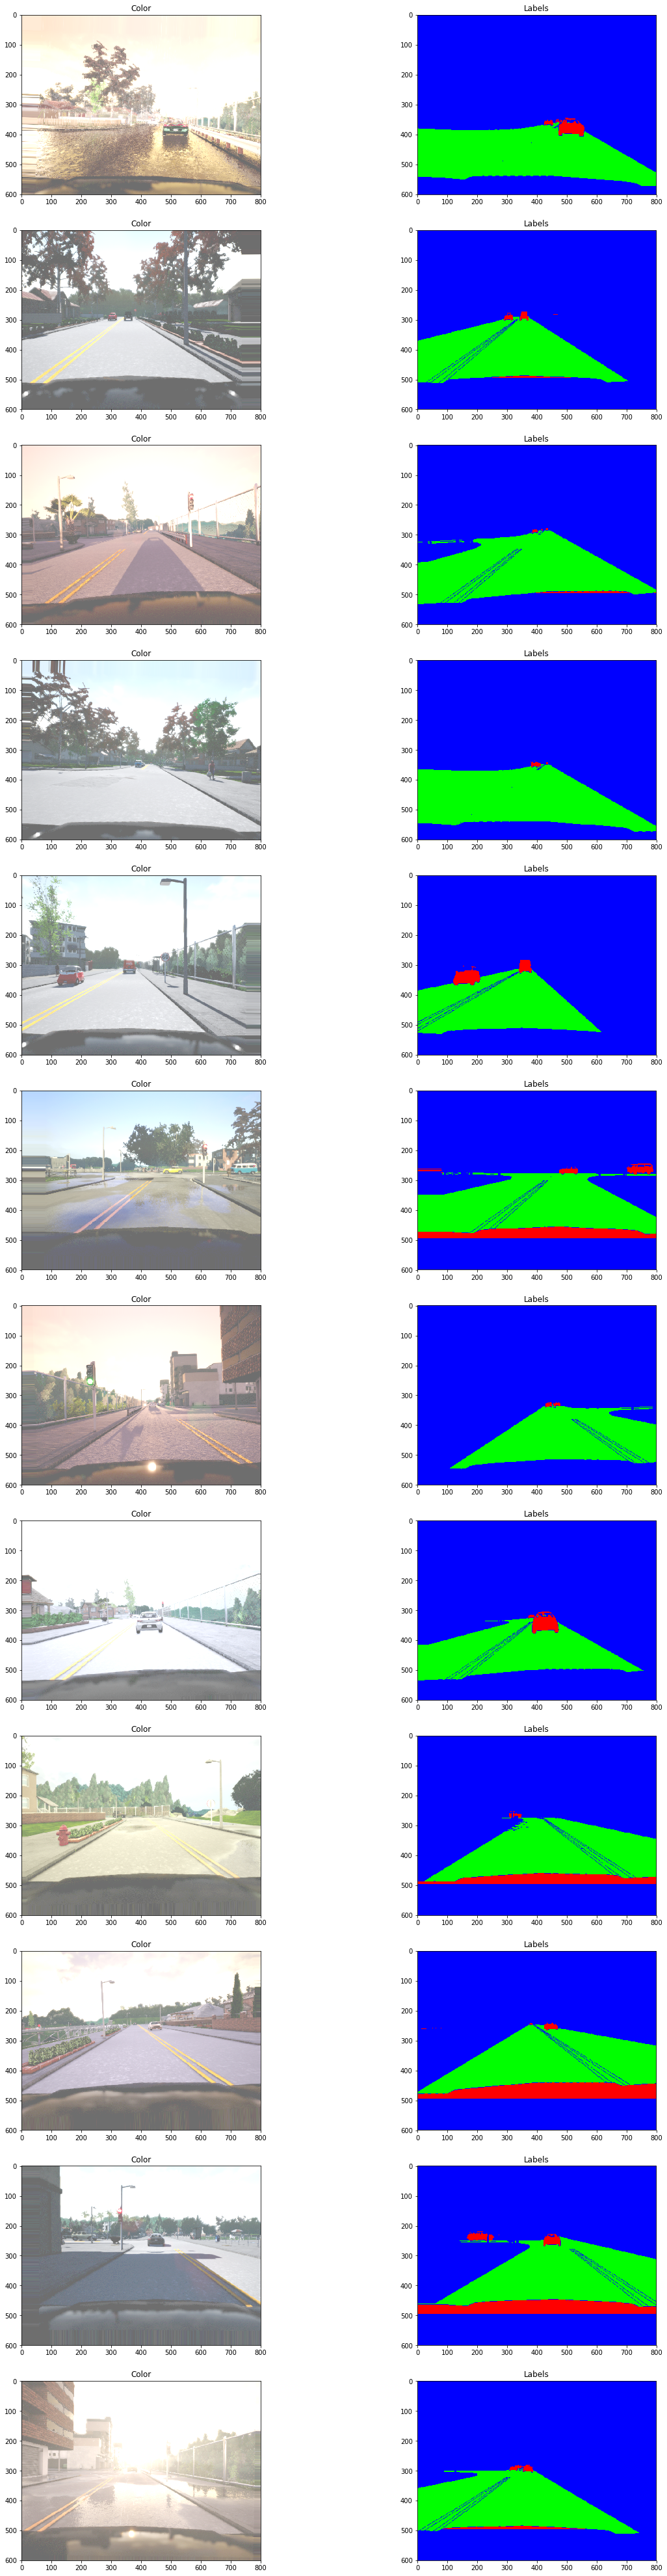

In [15]:
(rgb_batch, lab_batch) = next(train_and_lab_gen)

sample_rows = 12
fig, m_axs = plt.subplots(sample_rows, 2, figsize = (20, 6*sample_rows))
# [c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2), rgb_img, lab_img in zip(m_axs, rgb_batch, lab_batch):
    # undoing the vgg correction is tedious
    r_rgb_img = np.clip(rgb_img+110, 0, 255).astype(np.uint8)
    ax1.imshow(r_rgb_img)
    ax1.set_title('Color')
    ax2.imshow(lab_img)
    ax2.set_title('Labels')

In [ ]:
(rgb_batch, lab_batch) = next(valid_and_lab_gen)

sample_rows = 12
fig, m_axs = plt.subplots(sample_rows, 2, figsize = (20, 6*sample_rows))
# [c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2), rgb_img, lab_img in zip(m_axs, rgb_batch, lab_batch):
    # undoing the vgg correction is tedious
    r_rgb_img = np.clip(rgb_img+110, 0, 255).astype(np.uint8)
    ax1.imshow(r_rgb_img)
    ax1.set_title('Color')
    ax2.imshow(lab_img)
    ax2.set_title('Labels')

In [ ]:
(rgb_batch, lab_batch) = next(test_and_lab_gen)

sample_rows = 12
fig, m_axs = plt.subplots(sample_rows, 2, figsize = (20, 6*sample_rows))
# [c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2), rgb_img, lab_img in zip(m_axs, rgb_batch, lab_batch):
    # undoing the vgg correction is tedious
    r_rgb_img = np.clip(rgb_img+110, 0, 255).astype(np.uint8)
    ax1.imshow(r_rgb_img)
    ax1.set_title('Color')
    ax2.imshow(lab_img)
    ax2.set_title('Labels')

In [ ]:
import skvideo.io

video = skvideo.io.vread('../challenge_workspace/test_video.mp4')

plt.imshow(video[0])


In [ ]:
for i, row in train_df.sample(1500).iterrows():
    print (row)
    break

In [ ]:
from gen.generators import preprocess_label

bg, road, cars = 0, 0, 0
for i, row in train_df.sample(2500).iterrows():
    l = preprocess_label(imread(row['label']))
    
    cars += l[:, :, 0].nonzero()[1].shape[0]
    road += l[:, :, 1].nonzero()[1].shape[0]
    bg   += l[:, :, 2].nonzero()[1].shape[0]

print (bg, road, cars)

In [ ]:
t = bg + road + cars
car_p = cars/t * 100.0
road_p = road/t * 100.0
bg_p = bg/t * 100.0

In [ ]:
print ("Car {}%, Road {}%, BG {}%".format(car_p, road_p, bg_p))

In [ ]:
1/car_p

In [ ]:
1/road_p

In [ ]:
1/bg_p